In [ ]:
#import os
#print("CWD:", os.getcwd())


In [ ]:
!pip install polars 
!pip install lightgbm
!pip install pandas
!pip install scikit-learn
!pip install pyarrow


In [1]:
#imports
import os
import glob
import polars as pl
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

TRAIN_PARQ_DIR = "./csv_files/train/parquet/"
TEST_PARQ_DIR = "./csv_files/test/parquet/"


In [2]:
#loading base tables
train_base = pl.read_parquet(TRAIN_PARQ_DIR + "train_base.parquet")
test_base  = pl.read_parquet(TEST_PARQ_DIR + "test_base.parquet")

print("train_base:", train_base.shape)
print("test_base:", test_base.shape)


train_base: (1526659, 5)
test_base: (10, 4)


In [3]:
import polars as pl

def aggregate_by_case(df: pl.DataFrame, prefix: str) -> pl.DataFrame:
    """
    Aggregate a long table to one row per case_id.
    Numeric columns -> mean, std, min, max, sum, count.
    Uses only Polars (no pandas / pyarrow).
    """

    # treat all integer, float, and boolean columns as numeric
    numeric_types = (
        pl.Int8, pl.Int16, pl.Int32, pl.Int64,
        pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64,
        pl.Float32, pl.Float64,
        pl.Boolean,
    )

    numeric_cols = []
    for c, dt in zip(df.columns, df.dtypes):
        if c == "case_id":
            continue
        if dt in numeric_types:
            numeric_cols.append(c)

    print(f"[{prefix}] numeric columns: {len(numeric_cols)}")

    aggs = []
    for c in numeric_cols:
        aggs.extend([
            pl.col(c).mean().alias(f"{prefix}__{c}__mean"),
            pl.col(c).std().alias(f"{prefix}__{c}__std"),
            pl.col(c).min().alias(f"{prefix}__{c}__min"),
            pl.col(c).max().alias(f"{prefix}__{c}__max"),
            pl.col(c).sum().alias(f"{prefix}__{c}__sum"),
        ])

    # how many rows contributed for this case_id
    aggs.append(pl.len().alias(f"{prefix}__row_count"))

    out = df.group_by("case_id").agg(aggs)
    print(f"[{prefix}] aggregated shape: {out.shape}")
    return out


In [4]:
import glob
import polars as pl

def load_parquet_group(pattern: str, prefix: str) -> pl.DataFrame | None:
    files = glob.glob(pattern)
    print(f"[{prefix}] pattern: {pattern} -> {len(files)} files")

    if not files:
        print(f"[{prefix}] WARNING: no files found, skipping.\n")
        return None

    # read all files first
    dfs = [pl.read_parquet(f) for f in files]

    # find columns that are common to EVERY file
    common_cols = set(dfs[0].columns)
    for df in dfs[1:]:
        common_cols &= set(df.columns)

    common_cols = sorted(common_cols)

    # optional: print what was dropped (helps debugging)
    all_cols = set().union(*[set(df.columns) for df in dfs])
    dropped = sorted(all_cols - set(common_cols))
    if dropped:
        print(f"[{prefix}] dropping non-common columns: {dropped}")

    # select only those common columns from each df
    dfs = [df.select(common_cols) for df in dfs]

    # now concatenate safely
    out = pl.concat(dfs, how="vertical_relaxed")
    print(f"[{prefix}] raw shape: {out.shape}")
    return out


In [37]:
TRAIN_PARQ_DIR = "./csv_files/train/parquet/"
TEST_PARQ_DIR  = "./csv_files/test/parquet/"

groups = [
    # ---------- depth = 1 / base ----------
    ("applprev1",
     TRAIN_PARQ_DIR + "train_applprev_1_*.parquet",
     TEST_PARQ_DIR  + "test_applprev_1_*.parquet"),

    ("applprev2",  # depth = 2 (already had this)
     TRAIN_PARQ_DIR + "train_applprev_2.parquet",
     TEST_PARQ_DIR  + "test_applprev_2.parquet"),

    ("creditA",
     TRAIN_PARQ_DIR + "train_credit_bureau_a_*.parquet",
     TEST_PARQ_DIR  + "test_credit_bureau_a_*.parquet"),

    ("creditB1",
     TRAIN_PARQ_DIR + "train_credit_bureau_b_1.parquet",
     TEST_PARQ_DIR  + "test_credit_bureau_b_1.parquet"),

    ("creditB2",  # depth = 2 (already had this)
     TRAIN_PARQ_DIR + "train_credit_bureau_b_2.parquet",
     TEST_PARQ_DIR  + "test_credit_bureau_b_2.parquet"),

    ("debit1",
     TRAIN_PARQ_DIR + "train_debitcard_1.parquet",
     TEST_PARQ_DIR  + "test_debitcard_1.parquet"),

    ("deposit1",
     TRAIN_PARQ_DIR + "train_deposit_1.parquet",
     TEST_PARQ_DIR  + "test_deposit_1.parquet"),

    ("other1",
     TRAIN_PARQ_DIR + "train_other_1.parquet",
     TEST_PARQ_DIR  + "test_other_1.parquet"),

    ("taxA1",
     TRAIN_PARQ_DIR + "train_tax_registry_a_1.parquet",
     TEST_PARQ_DIR  + "test_tax_registry_a_1.parquet"),

    ("taxB1",
     TRAIN_PARQ_DIR + "train_tax_registry_b_1.parquet",
     TEST_PARQ_DIR  + "test_tax_registry_b_1.parquet"),

    ("taxC1",
     TRAIN_PARQ_DIR + "train_tax_registry_c_1.parquet",
     TEST_PARQ_DIR  + "test_tax_registry_c_1.parquet"),

    # ---------- depth = 2 additions ----------
    ("debit2",
     TRAIN_PARQ_DIR + "train_debitcard_2.parquet",
     TEST_PARQ_DIR  + "test_debitcard_2.parquet"),

    ("deposit2",
     TRAIN_PARQ_DIR + "train_deposit_2.parquet",
     TEST_PARQ_DIR  + "test_deposit_2.parquet"),

    ("other2",
     TRAIN_PARQ_DIR + "train_other_2.parquet",
     TEST_PARQ_DIR  + "test_other_2.parquet"),

    ("taxA2",
     TRAIN_PARQ_DIR + "train_tax_registry_a_2.parquet",
     TEST_PARQ_DIR  + "test_tax_registry_a_2.parquet"),

    ("taxB2",
     TRAIN_PARQ_DIR + "train_tax_registry_b_2.parquet",
     TEST_PARQ_DIR  + "test_tax_registry_b_2.parquet"),

    ("taxC2",
     TRAIN_PARQ_DIR + "train_tax_registry_c_2.parquet",
     TEST_PARQ_DIR  + "test_tax_registry_c_2.parquet"),
]


In [38]:
train_df = train_base
test_df  = test_base

for prefix, train_pattern, test_pattern in groups:
    print(f"\n=== Processing group: {prefix} ===")
    
    train_long = load_parquet_group(train_pattern, prefix + "_train")
    test_long  = load_parquet_group(test_pattern,  prefix + "_test")

    if train_long is None or test_long is None:
        print(f"[{prefix}] skipped (files missing)")
        continue

    train_agg = aggregate_by_case(train_long, prefix)
    test_agg  = aggregate_by_case(test_long,  prefix)

    # 🔧 NEW: ensure case_id has the same dtype (Int64) on both sides
    if "case_id" in train_agg.columns:
        train_agg = train_agg.with_columns(
            pl.col("case_id").cast(pl.Int64)
        )
    if "case_id" in test_agg.columns:
        test_agg = test_agg.with_columns(
            pl.col("case_id").cast(pl.Int64)
        )

    # left join on case_id
    train_df = train_df.join(train_agg, on="case_id", how="left")
    test_df  = test_df.join(test_agg,  on="case_id", how="left")

    print(f"[{prefix}] train_df shape now: {train_df.shape}")
    print(f"[{prefix}] test_df  shape now: {test_df.shape}")



=== Processing group: applprev1 ===
[applprev1_train] pattern: ./csv_files/train/parquet/train_applprev_1_*.parquet -> 2 files
[applprev1_train] raw shape: (6525979, 41)
[applprev1_test] pattern: ./csv_files/test/parquet/test_applprev_1_*.parquet -> 3 files
[applprev1_test] raw shape: (30, 41)
[applprev1] numeric columns: 21
[applprev1] aggregated shape: (1221522, 107)
[applprev1] numeric columns: 21
[applprev1] aggregated shape: (4, 107)
[applprev1] train_df shape now: (1526659, 111)
[applprev1] test_df  shape now: (10, 110)

=== Processing group: applprev2 ===
[applprev2_train] pattern: ./csv_files/train/parquet/train_applprev_2.parquet -> 1 files
[applprev2_train] raw shape: (14075487, 6)
[applprev2_test] pattern: ./csv_files/test/parquet/test_applprev_2.parquet -> 1 files
[applprev2_test] raw shape: (10, 6)
[applprev2] numeric columns: 2
[applprev2] aggregated shape: (1221522, 12)
[applprev2] numeric columns: 2
[applprev2] aggregated shape: (1, 12)
[applprev2] train_df shape now: 

In [54]:
import numpy as np
import pandas as pd

sample = pd.read_csv("./csv_files/sample_submission.csv")
ID_COL = sample.columns[0]      # usually 'case_id'
TARGET_COL = "target"           # given by competition

print(ID_COL, TARGET_COL)


case_id target


In [69]:
import polars as pl

NUMERIC_TYPES = (
    pl.Int8, pl.Int16, pl.Int32, pl.Int64,
    pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64,
    pl.Float32, pl.Float64,
)

# columns that appear in BOTH train_df and test_df
common_cols = set(train_df.columns) & set(test_df.columns)

# 1) find numeric columns in Polars (exclude ID + target, and keep only common cols)
numeric_cols = [
    c
    for c, dt in zip(train_df.columns, train_df.dtypes)
    if (dt in NUMERIC_TYPES)
       and (c not in [ID_COL, TARGET_COL])
       and (c in common_cols)
]

print("Numeric feature count:", len(numeric_cols))

# 2) build smaller Polars frames with downcasted types
train_small = (
    train_df
    .select([ID_COL, TARGET_COL] + numeric_cols)
    .with_columns(
        [
            pl.col(numeric_cols).cast(pl.Float32),
            pl.col(TARGET_COL).cast(pl.Int8),
        ]
    )
)

test_small = (
    test_df
    .select([ID_COL] + numeric_cols)
    .with_columns(
        [
            pl.col(numeric_cols).cast(pl.Float32),
        ]
    )
)

print("Reduced Polars shapes:", train_small.shape, test_small.shape)


Numeric feature count: 384
Reduced Polars shapes: (1526659, 386) (10, 385)


In [70]:
train_pd = train_small.to_pandas()
test_pd  = test_small.to_pandas()

print("Pandas shapes:", train_pd.shape, test_pd.shape)
train_pd.head()


Pandas shapes: (1526659, 386) (10, 385)


,case_id,target,MONTH,WEEK_NUM,applprev1__actualdpd_943P__mean,applprev1__actualdpd_943P__std,applprev1__actualdpd_943P__min,applprev1__actualdpd_943P__max,applprev1__actualdpd_943P__sum,applprev1__annuity_853A__mean,...,taxB1__amount_4917619A__min,taxB1__amount_4917619A__max,taxB1__amount_4917619A__sum,taxB1__num_group1__mean,taxB1__num_group1__std,taxB1__num_group1__min,taxB1__num_group1__max,taxB1__num_group1__sum,taxB1__row_count,taxC1__row_count
0,0,0,201901.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,201901.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,201901.0,0.0,0.0,0.0,0.0,0.0,0.0,1161.300049,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,201901.0,0.0,0.0,NaN,0.0,0.0,0.0,6140.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1,201901.0,0.0,0.0,NaN,0.0,0.0,0.0,2556.600098,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
print("Reduced Polars shapes:", train_small.shape, test_small.shape)
print("Pandas shapes:", train_pd.shape, test_pd.shape)


Reduced Polars shapes: (1526659, 386) (10, 385)
Pandas shapes: (1526659, 386) (10, 385)


In [72]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
)


In [73]:
from sklearn.model_selection import train_test_split

# all feature columns = everything except ID and target
feature_cols = [c for c in train_pd.columns if c not in [ID_COL, TARGET_COL]]
print("Num features:", len(feature_cols))

X = train_pd[feature_cols]
y = train_pd[TARGET_COL]
X_test = test_pd[feature_cols]

print("X:", X.shape, "X_test:", X_test.shape)


Num features: 384
X: (1526659, 384) X_test: (10, 384)


In [74]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "Val:", X_val.shape)


Train: (1221327, 384) Val: (305332, 384)


In [75]:
train_data = lgb.Dataset(X_train, label=y_train)
val_data   = lgb.Dataset(X_val, label=y_val)

params = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.05,
    "num_leaves": 63,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "verbose": -1,
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, val_data],
    valid_names=["train", "val"],
    num_boost_round=2000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=50),
    ],
)

val_pred = model.predict(X_val, num_iteration=model.best_iteration)
val_auc  = roc_auc_score(y_val, val_pred)
print("Validation AUC:", val_auc)


Training until validation scores don't improve for 100 rounds
[50]	train's auc: 0.762451	val's auc: 0.741041
[100]	train's auc: 0.781552	val's auc: 0.748961
[150]	train's auc: 0.796052	val's auc: 0.750904
[200]	train's auc: 0.806649	val's auc: 0.751556
[250]	train's auc: 0.815689	val's auc: 0.752102
[300]	train's auc: 0.824752	val's auc: 0.752403
[350]	train's auc: 0.833076	val's auc: 0.752626
[400]	train's auc: 0.84068	val's auc: 0.752899
[450]	train's auc: 0.847619	val's auc: 0.753045
[500]	train's auc: 0.853948	val's auc: 0.753339
[550]	train's auc: 0.859751	val's auc: 0.753406
[600]	train's auc: 0.865303	val's auc: 0.753441
Early stopping, best iteration is:
[526]	train's auc: 0.85711	val's auc: 0.75351
Validation AUC: 0.7535100349115427


In [76]:
# Precision-recall curve to choose threshold
precision, recall, thresholds = precision_recall_curve(y_val, val_pred)

# Avoid division by zero
f1s = 2 * (precision * recall) / (precision + recall + 1e-9)
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]

print("Best threshold:", best_threshold)

# Metrics at default 0.5
val_bin_05 = (val_pred > 0.5).astype(int)
acc_05 = accuracy_score(y_val, val_bin_05)
rec_05 = recall_score(y_val, val_bin_05)
prec_05 = precision_score(y_val, val_bin_05)
f1_05 = f1_score(y_val, val_bin_05)

print("\n=== Metrics at threshold 0.5 ===")
print("Accuracy:", acc_05)
print("Recall:",   rec_05)
print("Precision:",prec_05)
print("F1:",       f1_05)

# Metrics at best_threshold
val_bin_best = (val_pred > best_threshold).astype(int)
acc_best = accuracy_score(y_val, val_bin_best)
rec_best = recall_score(y_val, val_bin_best)
prec_best = precision_score(y_val, val_bin_best)
f1_best = f1_score(y_val, val_bin_best)

print("\n=== Metrics at best threshold ===")
print("Accuracy:", acc_best)
print("Recall:",   rec_best)
print("Precision:",prec_best)
print("F1:",       f1_best)

# PR-AUC
pr_auc = average_precision_score(y_val, val_pred)
print("\nPR-AUC:", pr_auc)


Best threshold: 0.09166439999048187

=== Metrics at threshold 0.5 ===
Accuracy: 0.9685326136795357
Recall: 0.002396082925304719
Precision: 0.41818181818181815
F1: 0.004764864304951316

=== Metrics at best threshold ===
Accuracy: 0.9281437910209215
Recall: 0.25200541723096154
Precision: 0.14081145584725538
F1: 0.18067069982821718

PR-AUC: 0.10998904212048412


In [77]:
test_pred = model.predict(X_test, num_iteration=model.best_iteration)

submission = pd.DataFrame({
    ID_COL: test_pd[ID_COL],
    "score": test_pred,
})

submission.to_csv("submission_full_parquet_model.csv", index=False)
submission.head()


,case_id,score
0,57543,0.053067
1,57549,0.034720
2,57551,0.037123
3,57552,0.016545
4,57569,0.014992


In [78]:
precision, recall, thresholds = precision_recall_curve(y_val, val_pred)
f1s = 2 * (precision * recall) / (precision + recall + 1e-9)
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]
print("Best threshold:", best_threshold)

val_bin_best = (val_pred > best_threshold).astype(int)
print("Accuracy:",      accuracy_score(y_val, val_bin_best))
print("Recall:",        recall_score(y_val, val_bin_best))
print("Precision:",     precision_score(y_val, val_bin_best))
print("F1:",            f1_score(y_val, val_bin_best))
print("PR-AUC:",        average_precision_score(y_val, val_pred))


Best threshold: 0.09166439999048187
Accuracy: 0.9281437910209215
Recall: 0.25200541723096154
Precision: 0.14081145584725538
F1: 0.18067069982821718
PR-AUC: 0.10998904212048412


PR-AUC: 0.10998904212048412


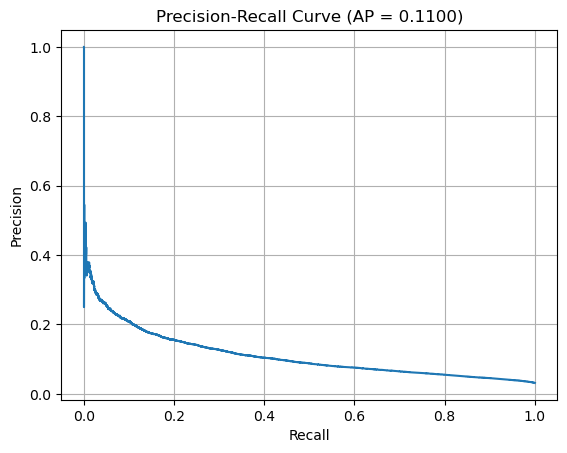

In [79]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# PR curve
precision, recall, pr_thresholds = precision_recall_curve(y_val, val_pred)
pr_auc = average_precision_score(y_val, val_pred)
print("PR-AUC:", pr_auc)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (AP = {pr_auc:.4f})")
plt.grid(True)
plt.show()


ROC-AUC: 0.7535100349115427


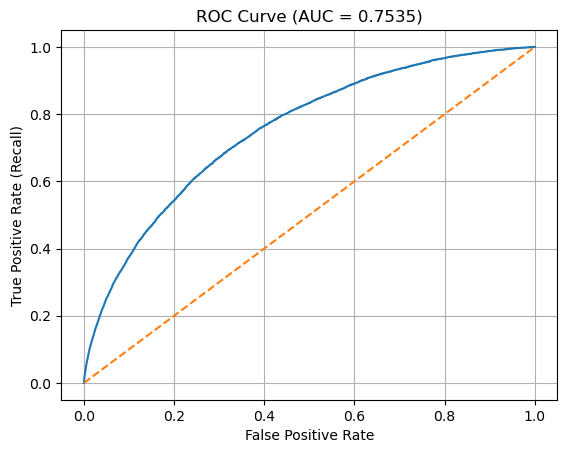

In [80]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, roc_thresholds = roc_curve(y_val, val_pred)
roc_auc = roc_auc_score(y_val, val_pred)
print("ROC-AUC:", roc_auc)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")  # random baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title(f"ROC Curve (AUC = {roc_auc:.4f})")
plt.grid(True)
plt.show()


In [81]:
from sklearn.metrics import confusion_matrix

th_default = 0.5
y_pred_05 = (val_pred >= th_default).astype(int)

cm_05 = confusion_matrix(y_val, y_pred_05)
tn_05, fp_05, fn_05, tp_05 = cm_05.ravel()

print("Confusion matrix @ threshold = 0.5")
print(cm_05)
print(f"TN={tn_05}, FP={fp_05}, FN={fn_05}, TP={tp_05}")


Confusion matrix @ threshold = 0.5
[[295701     32]
 [  9576     23]]
TN=295701, FP=32, FN=9576, TP=23


In [82]:
y_pred_best = (val_pred >= best_threshold).astype(int)

cm_best = confusion_matrix(y_val, y_pred_best)
tn_b, fp_b, fn_b, tp_b = cm_best.ravel()

print(f"Confusion matrix @ best threshold = {best_threshold:.6f}")
print(cm_best)
print(f"TN={tn_b}, FP={fp_b}, FN={fn_b}, TP={tp_b}")


Confusion matrix @ best threshold = 0.091664
[[280973  14760]
 [  7179   2420]]
TN=280973, FP=14760, FN=7179, TP=2420
